# Activity 4.1. EM for GMM
In this activity we practice Hard and Soft Expectation Maximimization to train Gaussian Mixture Models.

## Libraries
In this activity we need to use some special packages to generate synthetic data and sample from gaussian mixture models. In particular, we use `mvtnorm` for generating  multivariate Gaussian sampels and `clusterGeneration` for generating covariance matrices. 

In [1]:
options(warn=-1)
library(mvtnorm) # generates multivariate Gaussian sampels and calculate the densities
library(ggplot2) # plotting
library(reshape2) # data wrangling!
library(clusterGeneration) # generates the covariance matrices that we need for producing synthetic data.

Loading required package: MASS


## Synthetic Data Generation
In this part we mix samples from a few Gaussian distribution to produce Gaussian mixtures. In the next steps we try to train a mixture model based on these samples.

Let's start with setting the main parameters...

In [2]:
# Set the parameters:
set.seed(12345) # save the random seed to make the results reproducble
N <- 1000       # number of samples
K <- 3          # number of clusters
D <- 2          # number of dimensions

... and then initiating the matrices

In [3]:
# Initializations:
Phi   <- runif(K); Phi <- Phi/sum(Phi)    # Phi(k) indicates the fraction of samples that are from cluster k (i.e. probability/proportion)
Nk    <- matrix(0,nrow = K)    # initiate  the effective number of points assigned to each cluster - empty matrix of 0
Mu    <- matrix(runif(K*D, min=-1)*10,nrow = K, ncol = D)    # initiate the centriods (means) of the clusters (randomly chosen)
Sigma <- matrix(0,nrow = K, ncol = D^2)    # initiate the covariance matrix

Now, we can easily create covariance matrices

In [4]:
# Create the covariance matrices:
for (k in 1:K){
    # For each cluster generate one sigma matrix
    Sigma[k,] <- genPositiveDefMat(D)$Sigma[1:D^2]
}
Sigma

1.664434,1.7073136,1.7073136,9.554017
2.461010,-1.7286836,-1.7286836,3.070050
4.249773,0.7814841,0.7814841,2.983265


OK! Now we ready to generate our synthetic data. Note that we should remove the labales as the EM algorithm should be able to cluster the points without knowing the real cluster labels.

In [5]:
# Generate data:
data <- data.frame(K=integer(), X1=double(), X2=double()) # empty dataset
data[1:N,'K'] <- sample(1:K, N, replace = TRUE, prob = Phi) # geenrate labels (they will not be used in EM, just for validation)

## For each cluster k:
for (k in 1:K){
    ### calculate the effective number of points assigned to it: 
    Nk[k] <- sum(data$K==k)
    
    ### generate the actual points: - points here mean the x1 and x2 values for a given K based on the 
    ### distribution for that K. It uses the value of N at k, Sigma at k and mean at k to generate the distribution
    ### and sample from it.
    data[data$K==k, 2:3] <- rmvnorm(n = Nk[k], Mu[k,], matrix(Sigma[k,], ncol=D))
}

# Remove the lables! So, our GMM has no clue what the real labels are.
X <- as.matrix(data[,-1]) 



To finish this part, let's take a quick look at the generated data.

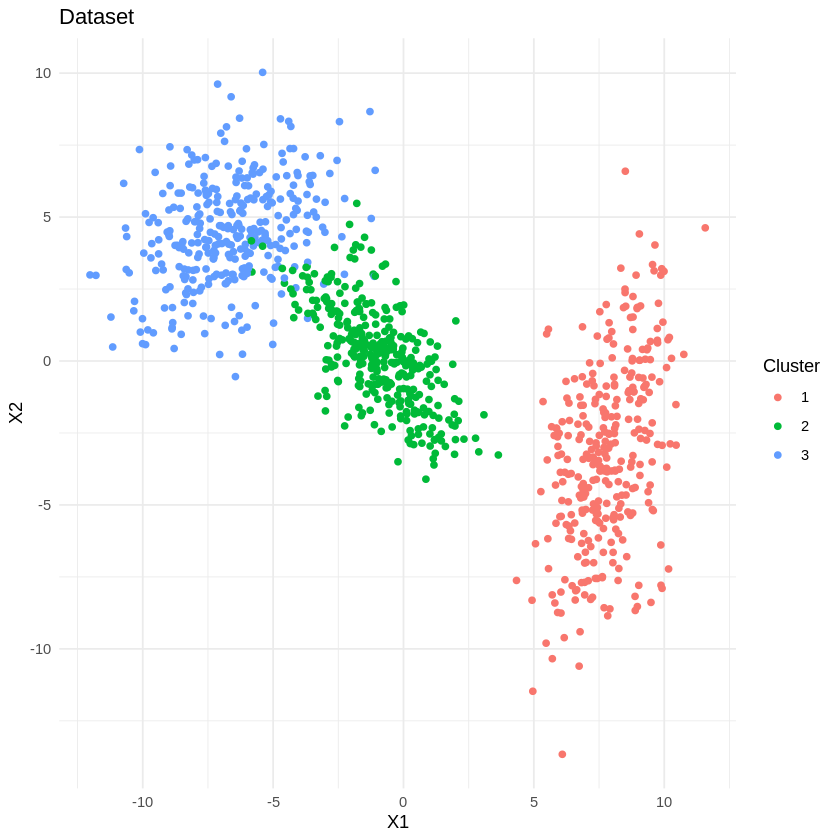

In [6]:
# Visualize the data (with the real labels)
ggplot(data=data, aes(x=X1, y=X2, color=factor(K))) + 
    geom_point() +
    scale_color_discrete(guide = guide_legend(title = "Cluster")) + 
    ggtitle ('Dataset') + 
    theme_minimal()

## Soft EM for GMM
We generated our data previously, so we know the real cluster labels. However, we pretend we do not have the real lables. Let's implement Soft Expectation Maximization for our GMM. Again we use `.hat` name convention to differentiate the real and estimated values. 

Let's set the parameters and then perform the initializations.

In [7]:
# Setting the parameters:
eta.max <- 100      # maximum number of iteratins
epsilon <- 0.01     # termination threshold 

# Initialzations:
eta <- 1            # epoch counter
terminate <- FALSE  # termination condition

## Ramdom cluster initialization:
set.seed(123456)                           # save the random seed to make the results reproducble
Phi.hat <- 1/K                             # assume all clusters have the same size (we will update this later on)
Nk.hat  <- matrix(N/K,nrow = K)            # refer to the above line! If all clusters have the same size N for each K must be equal
Mu.hat  <- as.matrix(X[sample(1:N, K), ])  # randomly choose K samples as cluster means (any better idea?)
Sigma.hat <- matrix(,nrow = K, ncol = D^2) # create empty covariance matrices (we will fill them)
post    <- matrix(,nrow=N, ncol=K)         # empty posterior matrix (the membership estimates will be stored here)

### for each cluster k:
for (k in 1:K){
    #### initiate the k covariance matrix as an identity matrix (we will update it later on)
    Sigma.hat[k,] <- diag(D) # initialize with identity covariance matrix (any better idea?)
}

The following is the main loop of EM algorithm. In this loop, we iteratively take **E** and __M__ steps until the termination criterion is met.

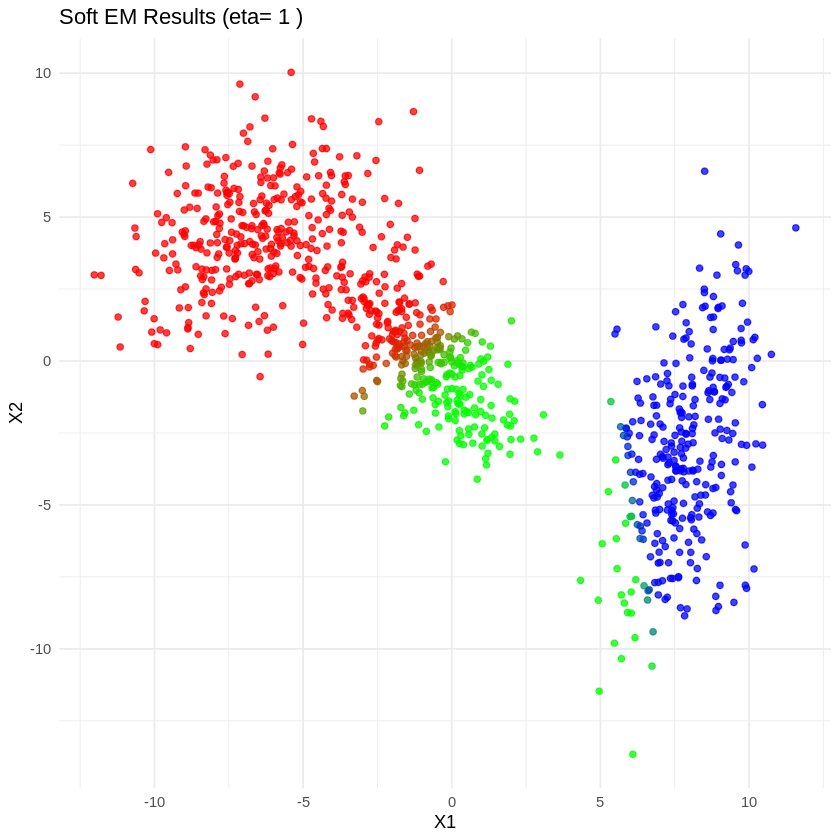

maximum number of itterations: 21 


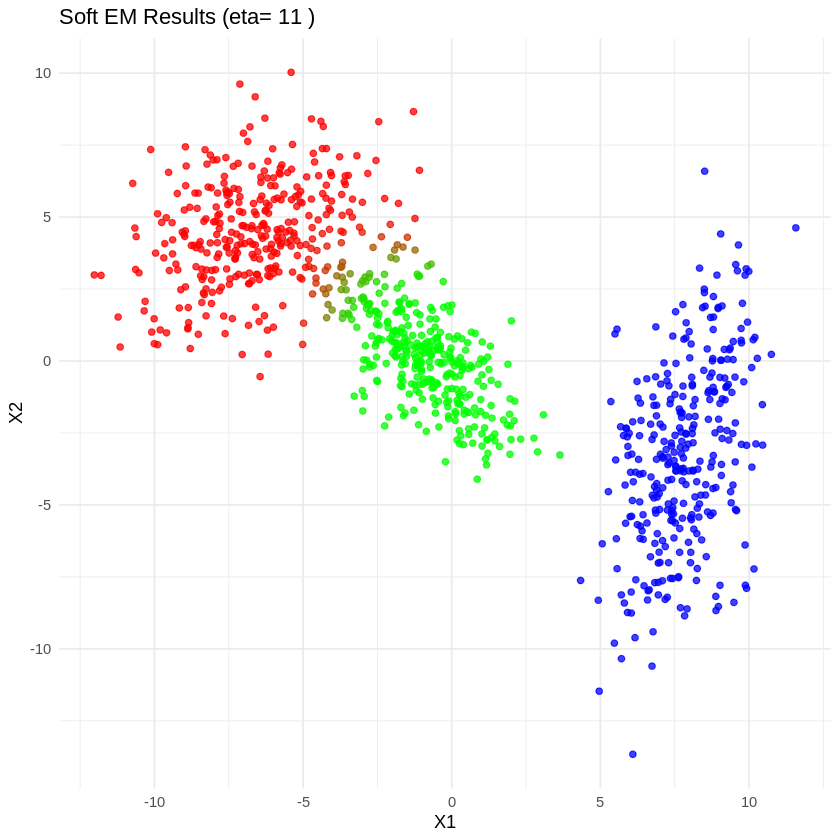

In [8]:
# Build the GMM model
Mu.hat.old <- Mu.hat # store the old estimated means

while (!terminate){
    
    # E step:    
    for (k in 1:K){
        
        ## calculate the posterior based on the estimated means, covariance and cluster size:
        ## We sample from a distribution that has the same estimates for its distribution as we had suspected
        ## In this case it is equal membership across the clusters with randomly selected means
        post[,k] <- dmvnorm(X, Mu.hat[k,],  matrix(Sigma.hat[k,], ncol=D)) * Nk.hat[k]
    }
    post <- post/rowSums(post) # normalization (to make sure post(k) is in [0,1] and sum(post)=1)

    ### Because the posterior distributions are probabilistic around the .hat values for our covariance matrix
    ### we will get some variation in actual values. We can use this variation to update our estimations in the
    ### M step
    
    # M step:
    for (k in 1:K){
        
        ## recalculate the estimations:
        Nk.hat[k]  <- sum(post[,k])        # the effective number of point in cluster k - i.e. the points assigned
        Phi.hat[k] <- Nk.hat[k]/N          # the new relative cluster size i.e. not all the same size
        Mu.hat[k,] <- colSums(post[,k] *X)/Nk.hat[k] # new means (cluster cenroids)
        
        ## This is the  ΣΣnewk=1Nk∑Nn=1γ(znk)(xxn–μμk)(xxn–μμk)T equation for coveriance
        Sigma.hat[k,] <- (t(X-matrix(Mu.hat[k,],nrow = N, ncol=D, byrow = TRUE))%*%
                          (post[,k]*(X-matrix(Mu.hat[k,],nrow = N, ncol=D, byrow = TRUE))))/Nk.hat[k] # new covariance
    
    }

    if (eta %% 10 ==1) {  ## This is to plot the output at 1st, 11th, 21st, ... runs only.
        print(ggplot(data=as.data.frame(X), aes(x=X1, y=X2)) + 
            geom_point(color=rgb(post), alpha=0.75) +
            ggtitle (paste('Soft EM Results (eta=', eta, ')')) + 
            theme_minimal())
        }
    
    # increase the epoch counter
    eta <- eta + 1
    
    # check the termination criteria
    terminate <- eta > eta.max | sum(abs(Mu.hat.old - Mu.hat)) <= epsilon
    
    # record the means (neccessary for checking the termination criteria)
    Mu.hat.old <- Mu.hat

}
# That's it! Let see how many iterations we had:
cat('maximum number of itterations:',eta,'\n')

<div class="alert alert-info" role="alert">
The color code of the above figure(s) can be very different than the plot we draw using the real labels. This happens because the order of the estimated culsters may not be the same as the real order of the clusters.
</div>

As we observe in the plot(s), the intensity of the color of a particular point indicates the probability of that point being from the cluster which that color associated with. As a result, we see points with mixing colors (this is specific to soft assignment).

## Discussions
1- We built a GMM using soft EM and visualized it. Other than visualization, one can compare the real (generative) and estimated parameters to validate the formed clusters. Perform this comparison for mean, covariance and effective number of points in each clusters, then discuss your findings. 
Note that the order of clusters, and hence their means, covariances, etc., may vary as EM has no idea about the real order of the clusters in the generation process. To make it easier to compare these values, you can sort them before comparing them.


## Hard EM for GMM
In the above experiments, we implemented Soft EM. Now, we modify the code and develop a Hard EM for our GMM. Recal that in hard EM, $\gamma(z_{nk})$ only takes binary values as a data point either is a member of a cluster or not. To spot the difference between hard and soft EM, refer to the lines that are marked by `# hard assignments`.

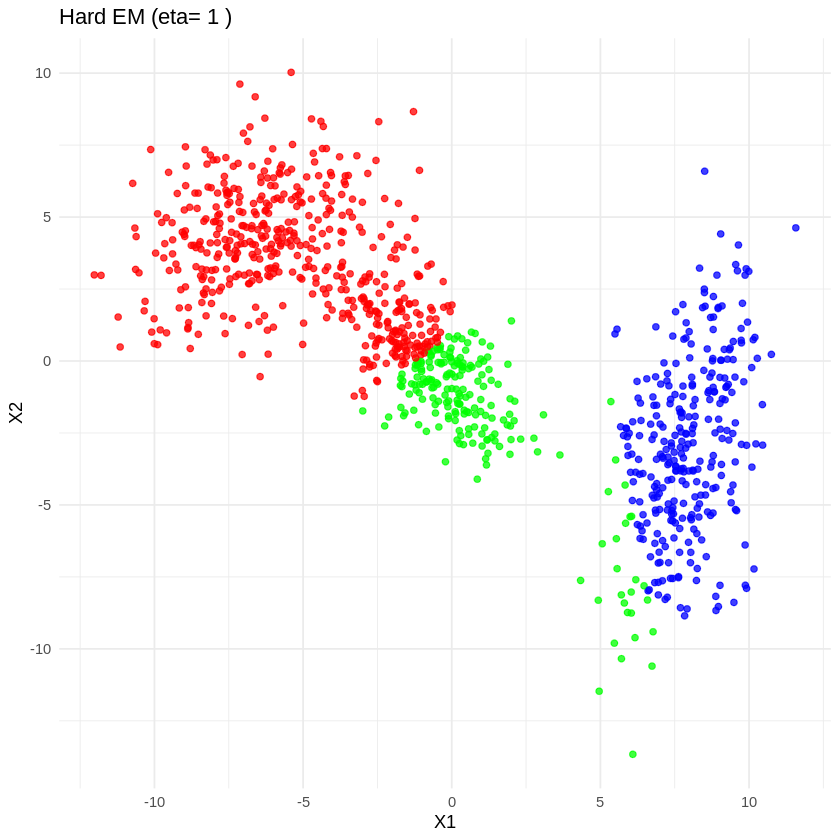

maximum number of itterations: 16 


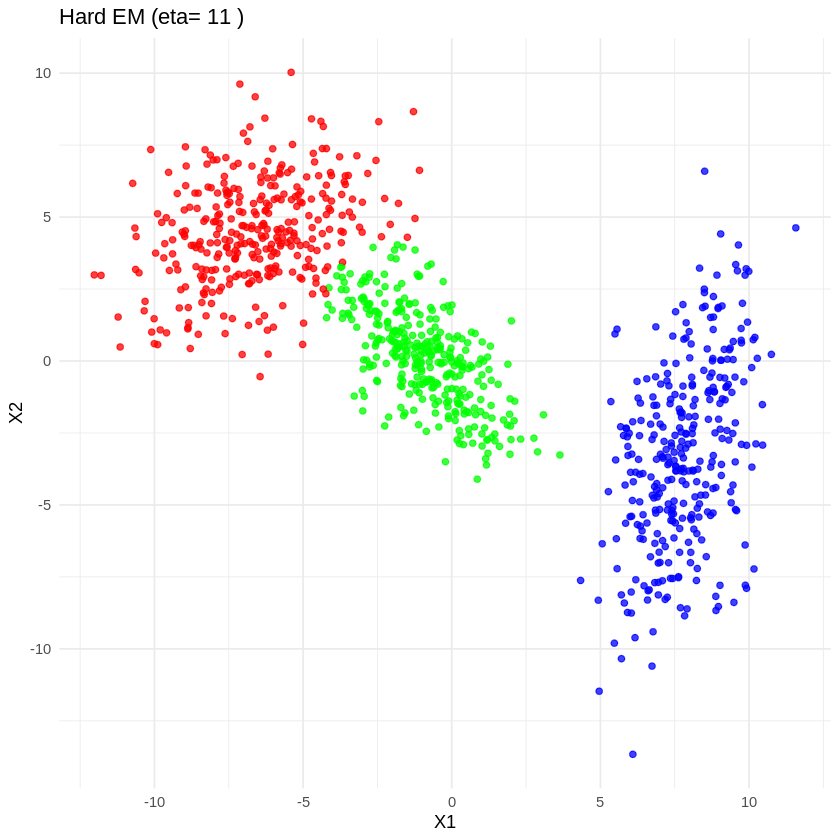

In [11]:
# Setting the parameters:
eta.max <- 100      # maximum number of iteratins
epsilon <- 0.01  # termination threshold 

# Initialzations:
eta <- 1            # epoch counter
terminate <- FALSE  # termination condition

## Ramdom cluster initialization:
set.seed(123456) # save the random seed to make the results reproducble
Phi.hat <- 1/K                             # assume all clusters have the same size (we will update this later on)
Nk.hat  <- matrix(N/K,nrow = K)            # refer to the above line!
Mu.hat  <- as.matrix(X[sample(1:N, K), ])  # randomly  choose K samples as cluster means (any better idea?)
Sigma.hat <- matrix(,nrow = K, ncol = D^2) # create empty covariance matrices (we will fill them)
post    <- matrix(,nrow=N, ncol=K)         # empty posterior matrix (the membership estimates will be stored here)

### for each cluster k:
for (k in 1:K){
    #### initiate the k covariance matrix as an identity matrix (we will update it later on)
    Sigma.hat[k,] <- diag(D) # initialize with identity covariance matrix
}

# Build the GMM model
Mu.hat.old <- Mu.hat # store the old estimated means

# Main Loop
while (!terminate){

    # E step:   
    for (k in 1:K){
        ## calculate the posterior based on the estimated means,covariance and cluster size:
        post[,k] <- dmvnorm(X, Mu.hat[k,],  matrix(Sigma.hat[k,], ncol=D)) * Nk.hat[k]
    }
    
    # hard assignments:
    max.prob <- post==apply(post, 1, max) # for each point find the cluster with the maximum (estimated) probability
    post[max.prob] <- 1  # assign each point to the cluster with the highest probability
    post[!max.prob] <- 0 # remove points from clusters with lower probabilites


    # M step:
    for (k in 1:K){
        ## recalculate the estimations:
        Nk.hat[k] <- sum(post[,k])        # the effective number of point in cluster k
        Phi.hat[k] <- sum(post[,k])/N     # the relative cluster size
        Mu.hat[k,] <- colSums(post[,k] *X)/Nk.hat[k] # new means (cluster cenroids)
        Sigma.hat[k,] <- (t(X-matrix(Mu.hat[k,],nrow = N, ncol=D, byrow = TRUE))%*%
                          (post[,k]*(X-matrix(Mu.hat[k,],nrow = N, ncol=D, byrow = TRUE))))/Nk.hat[k] # new covariance
    
    }
    
    # visualization
    if (eta %% 10 == 1){
        print(ggplot(data=as.data.frame(X), aes(x=X1, y=X2)) + 
        geom_point(color=rgb(post), alpha=0.75) +
        ggtitle (paste('Hard EM (eta=', eta,')')) + theme_minimal())
    }
    par(new=FALSE)
    # increase the epoch counter
    eta <- eta+1
    
    # check the termination criteria
    terminate <- eta > eta.max | sum(abs(Mu.hat.old - Mu.hat)) <= epsilon
    
    # record the means (neccessary for checking the termination criteria)
    Mu.hat.old <- Mu.hat
}
# That's it! Let see how many iterations we had:
cat('maximum number of itterations:',eta,'\n')

In contrast with soft assignments, here each point is only assigned to one cluster. Therefore, we do not see any point with mixed colors.

## Discussions

### Initialization Effect
In the above experiments, we used a simple but reasonably good initialization. Try some other initializations, reapet the experiments and study the results. For example, you can change

`Mu.hat <- as.matrix(X[sample(1:N, K), ]) # randomly choose K samples as cluster means`

to 

`Mu.hat <- matrix(0, nrow = K, ncol = D) # initialize all cluster means to the origin`

or

`Sigma.hat[k,] <- diag(D) # initialize with identity covariance matrix`

to 

`Sigma.hat[k,] <- genPositiveDefMat(D)$Sigma[1:D^2] # initialize with random covariance matrix`

### Kmeans vs. GMM
Discuss the followings:
* What are the main differences between Kmeans clustering and (hard) GMM? Explain the assumptions behind each one of them, as well as their limitaitons and strength (**Hint:** Think about the covariance matrix!).
* How one can combine Kmeans and GMM to have the bests of both worlds (**Hint:** Think about GMM initialization)?